## Global Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time

## Setup Jupyter Notebook data visualisaton params

In [2]:
from pylab import rcParams
import seaborn as sb

%matplotlib inline
rcParams['figure.figsize'] = 15, 12
sb.set_style('whitegrid')

## Import dataset

In [3]:
address = '../datasets/staandelamp_realistic.json'
df_data = pd.read_json(address)

# Sort the data on timestamp
df_data = df_data.sort_values(by=['time'])


# Grab around 6 hours of timestamps
### TEMP ###
df_data = df_data[:42]
### TEMP ###

df_data.head()

,name,state,time
2,Staande_Lamp_3,0,1509489940655
6,Staande_Lamp_5,1,1509490011225
0,Staande_Lamp_1,1,1509491943009
1,Staande_Lamp_2,0,1509492221471
3,Staande_Lamp_3,1,1509492826941


### (optional) Make a dataset for debugging purposes (so the date and time is human-readable) 

In [4]:
import datetime
import time
df_printable_dates = pd.DataFrame()
df_printable_dates['time'] = df_data['time']
df_printable_dates['printable_dates'] = df_data['time'].map(lambda x: datetime.datetime.fromtimestamp(x / 1000).isoformat())

df_printable_dates.head()

,time,printable_dates
2,1509489940655,2017-10-31T23:45:40.655000
6,1509490011225,2017-10-31T23:46:51.225000
0,1509491943009,2017-11-01T00:19:03.009000
1,1509492221471,2017-11-01T00:23:41.471000
3,1509492826941,2017-11-01T00:33:46.941000


# Determine the number of clusters (linkage)

#### only interested in column TIME

In [5]:

X = df_data.iloc[ :, [2] ].values
#                 :        All the rows
#                    [2]   Only column 2 (time)

X[:5]

array([[1509489940655],
       [1509490011225],
       [1509491943009],
       [1509492221471],
       [1509492826941]], dtype=int64)

##### Plot the timestamps and a line indicating 10 minutes

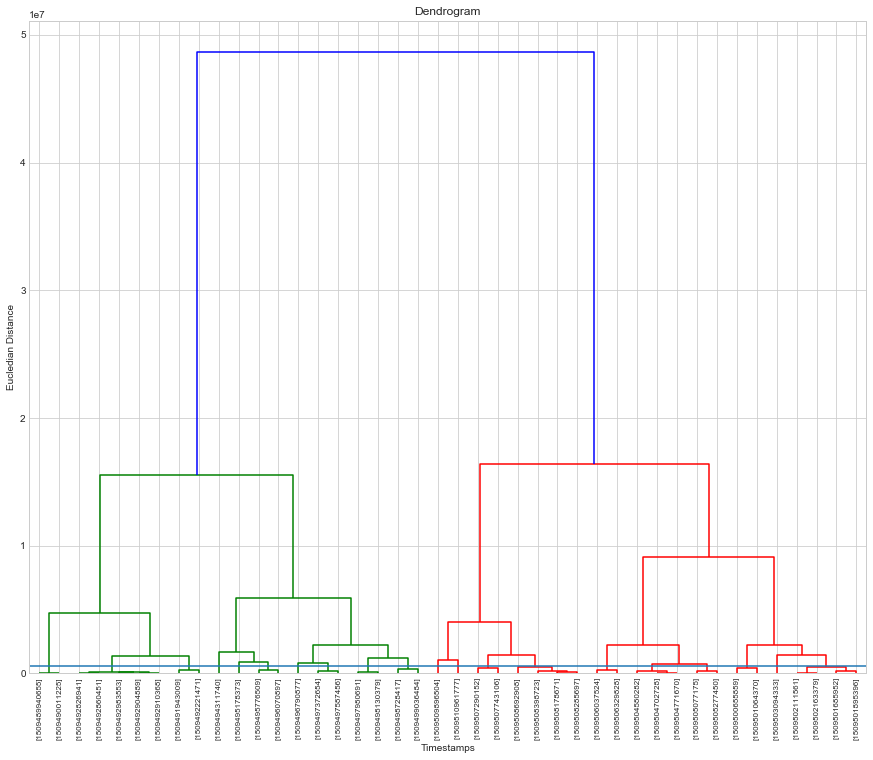

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X, method='ward')
gram = dendrogram(
    Z, 
    labels=X
    # truncate_mode='lastp', 
    # p=12, 
    # leaf_rotation=45., 
    # leaf_font_size=15., 
    # show_contracted=True
)
plt.title('Dendrogram')
plt.xlabel('Timestamps')
plt.ylabel('Eucledian Distance')

# This line represents a distance of 10 minutes
plt.axhline(y=600000)

In [34]:
# Debug Z

for idx, val in enumerate(Z):
    print(
        'datapoint:', idx,
        '\nval:', val, 
        '\n\n'
    )

datapoint: 0 
val: [6.000e+00 7.000e+00 5.479e+03 2.000e+00] 


datapoint: 1 
val: [4.000e+00 5.000e+00 3.351e+04 2.000e+00] 


datapoint: 2 
val: [2.4000e+01 2.5000e+01 5.1818e+04 2.0000e+00] 


datapoint: 3 
val: [2.8000e+01 2.9000e+01 6.8942e+04 2.0000e+00] 


datapoint: 4 
val: [0.000e+00 1.000e+00 7.057e+04 2.000e+00] 


datapoint: 5 
val: [8.0000000e+00 4.2000000e+01 8.7670061e+04 3.0000000e+00] 


datapoint: 6 
val: [3.60000e+01 3.70000e+01 1.07026e+05 2.00000e+00] 


datapoint: 7 
val: [4.30000000e+01 4.70000000e+01 1.38251046e+05 5.00000000e+00] 


datapoint: 8 
val: [1.60000e+01 1.70000e+01 1.49688e+05 2.00000e+00] 


datapoint: 9 
val: [2.70000000e+01 4.50000000e+01 1.81192144e+05 3.00000000e+00] 


datapoint: 10 
val: [3.80000000e+01 4.80000000e+01 1.92302673e+05 3.00000000e+00] 


datapoint: 11 
val: [3.00000e+01 3.10000e+01 2.00275e+05 2.00000e+00] 


datapoint: 12 
val: [2.20000e+01 2.30000e+01 2.09444e+05 2.00000e+00] 


datapoint: 13 
val: [1.40000e+01 1.50000e+01 2.14

# AgglomerativeClustering

In [7]:
## Format the dataset to be all numbers

In [8]:
# from sklearn.preprocessing import LabelEncoder
# from collections import defaultdict
# 
# print('before:\n', df_data.head())
# 
# d = defaultdict(LabelEncoder)
# df_fit = df_data.apply(lambda x: d[x.name].fit_transform(x))
# df_fit['time'] = df_data['time']
# print('after:\n', df_fit.head())

In [9]:
# from sklearn.cluster import AgglomerativeClustering
# 
# amountOfDataRows = df_fit['name'].size
# 
# model = AgglomerativeClustering(
#     affinity='euclidean', 
#     compute_full_tree='auto',
#     connectivity=None, 
#     linkage='ward', 
#     memory=None, 
#     n_clusters=amountOfDataRows - 1,
#     pooling_func='deprecated'
# ).fit(df_fit)
# 
# model